In [189]:
import pandas as pd
from IPython.display import display

In [190]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [191]:
data = pd.read_csv("modifiedData.csv")

In [192]:
# data_test = pd.read_csv("data_test.csv")

In [193]:
# columns = ['cps19_fed_gov_sat', 'cps19_spend_env', 'cps19_fed_id', 'cps19_province', 'cps19_education', 'cps19_age', 'cps19_imp_iss_party']

In [194]:
X = data.copy().drop(["votechoice"], axis=1)
y = data.copy().loc[:, "votechoice"]

In [195]:
from sklearn.model_selection import train_test_split

In [196]:
# X_test, y_test = data_test.copy()[columns], pd.read_csv("answers.csv", sep=";")

In [197]:
def linear_imputation(_df, cols):
    df = _df.copy()
    return df[cols].interpolate(method='linear')

In [198]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].dropna().unique(), 0)}


def integer_encode(df , variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)


def knn_imputation(_df , cols, n_neighbors=1):
    mm = MinMaxScaler()
    _mapping = dict()
    
    df = _df.copy()
    for variable in cols:
        mappings = find_category_mappings(df, variable)
        _mapping[variable] = mappings

    for variable in cols:
        integer_encode(df, variable, _mapping[variable])  

    sca = mm.fit_transform(df)
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    knn = knn_imputer.fit_transform(sca)
    df.iloc[:,:] = mm.inverse_transform(knn)
    for i in df.columns : 
        df[i] = round(df[i]).astype('int')

    for i in cols:
        inv_map = {v: k for k, v in _mapping[i].items()}
        df[i] = df[i].map(inv_map)
    return df


In [199]:
# X_train = linear_imputation(X_train, columns)

In [200]:
# X_test = linear_imputation(X_test, columns)

In [201]:
# X = knn_imputation(X, columns)

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=111)

In [203]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [204]:
# column_trans = make_column_transformer(
#                     (OneHotEncoder(), list(X_train.select_dtypes('object').columns)), 
#                     remainder='passthrough'
#                )

In [205]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [206]:
RANDOM_STATE = 66

In [207]:
# ensemble_clfs = [
#     (
#         "RandomForestClassifier, max_features='sqrt'",
#         make_pipeline(
#             column_trans,
#             RandomForestClassifier(
#                 warm_start=True,
#                 oob_score=True,
#                 max_features="sqrt",
#                 random_state=RANDOM_STATE,
#             )
#         ),
#     ),
#     (
#         "RandomForestClassifier, max_features='log2'",
#         make_pipeline(
#             column_trans,
#             RandomForestClassifier(
#                 warm_start=True,
#                 max_features="log2",
#                 oob_score=True,
#                 random_state=RANDOM_STATE,
#             )
#         ),
#     ),
#     (
#         "RandomForestClassifier, max_features=None",
#         make_pipeline(
#             column_trans,
#             RandomForestClassifier(
#                 warm_start=True,
#                 max_features=None,
#                 oob_score=True,
#                 random_state=RANDOM_STATE,
#             ) 
#         ),
#     ),
# ]

In [208]:
from collections import OrderedDict
import matplotlib.pyplot as plt

In [209]:
# ensemble_clfs[0][1].get_params()

In [210]:
import warnings
warnings.filterwarnings("ignore")

In [211]:
# min_estimators = 15
# max_estimators = 150

# error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# for label, clf in ensemble_clfs:
#     for i in range(min_estimators, max_estimators + 1, 5):
#         clf.set_params(randomforestclassifier__n_estimators=i)
#         clf.fit(X_train, y_train)

#         # Record the OOB error for each `n_estimators=i` setting.
#         oob_error = 1 - clf["randomforestclassifier"].oob_score_
#         error_rate[label].append((i, oob_error))

# # Generate the "OOB error rate" vs. "n_estimators" plot.
# for label, clf_err in error_rate.items():
#     xs, ys = zip(*clf_err)
#     plt.plot(xs, ys, label=label)

# plt.xlim(min_estimators, max_estimators)
# plt.xlabel("n_estimators")
# plt.ylabel("OOB error rate")
# plt.legend(loc="upper right")
# plt.show()

In [212]:
import numpy as np
from sklearn.model_selection import cross_validate

In [213]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted']

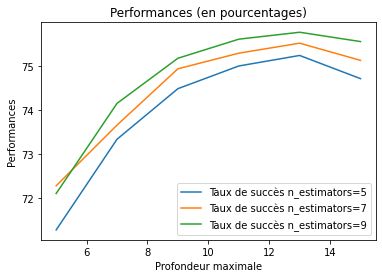

In [439]:
min_estimators, max_estimators = 5, 10
profondeur_min, profondeur_max = 5, 15

res = []

for n in range(min_estimators, max_estimators + 1, 2):
    result = dict()
    columns = ['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_precision_weighted', 'train_precision_weighted', 'test_recall_weighted', 'train_recall_weighted']
    for col in columns:
        result[col] = list()

    for d in range(profondeur_min, profondeur_max + 1, 2):        
        pipe = RandomForestClassifier(
                        n_estimators=n, 
                        max_depth=d, 
                        max_features="sqrt", 
                        random_state=RANDOM_STATE
                    )

        result_cv = cross_validate(pipe, X, y, cv=5, scoring=scoring, return_train_score=True)
        for col in columns:
            if col is 'fit_time' or col is 'score_time':
                result[col].append(np.sum(result_cv[col]))
            else:
                result[col].append(100 * np.mean(result_cv[col]))
    res.append(result)

for index, result in enumerate(res):
    # plt.figure(figsize=(30, 15))

    # plt.subplot(121)
    plt.plot(list(range(profondeur_min, profondeur_max + 1, 2)), result['test_accuracy'], label="Taux de succès n_estimators=%d" % (5 + index * 2))
    # plt.plot(list(range(profondeur_min, profondeur_max + 1, 2)), result['test_precision_weighted'], label="Précision")
    # plt.plot(list(range(profondeur_min, profondeur_max + 1, 2)), result['test_recall_weighted'], label="Rappel")

    # plt.subplot(122)
    # plt.plot(list(range(profondeur_min, profondeur_max + 1, 2)), result['fit_time'], label="Temps d'entrainement")
    # plt.plot(list(range(profondeur_min, profondeur_max + 1, 2)), result['score_time'], label="Temps de test de performance")

    # plt.xlabel("Profondeur maximale")
    # plt.ylabel("Temps")

    # plt.title("Temps (en secondes) pour n_estimators = %d" % n)
    # plt.legend()
    
    # plt.savefig("img/RandomForest %d" % d)
    # plt.show()
plt.xlabel("Profondeur maximale")
plt.ylabel("Performances")

plt.title("Performances (en pourcentages)")
plt.legend()

In [318]:
# pipe = make_pipeline(
#     column_trans, 
#     RandomForestClassifier(
#         n_estimators=12, 
#         warm_start=True,
#         max_features="log2",
#         random_state=RANDOM_STATE
#     )
# )

In [444]:
pipe = RandomForestClassifier(
        max_features="sqrt",
        n_estimators=7, 
        max_depth=11,
        random_state=RANDOM_STATE
    )

In [445]:
pipe.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, max_features='sqrt', n_estimators=7,
                       random_state=66)

In [429]:
# y_pred = pd.concat([
#     data["Unnamed: 0.1"], 
#     pd.DataFrame(
#         pipe.predict(X_test), 
#         columns=["Party"], 
#         dtype=object
#     )["Party"]
# ], axis=1).rename(columns = {'Unnamed: 0.1': 'Indiv'})
# y_pred.head()

In [430]:
y_pred = pd.DataFrame(pipe.predict(X_test), columns=["votechoice"], dtype=object)

In [454]:
y_pred.to_csv("train_test_predict.csv", index=False)

In [431]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [432]:
accuracy_score(y_pred["votechoice"], y_test)

0.7509411050394657

In [433]:
avgs = ["micro", "macro", "weighted"]

In [434]:
for avg in avgs:
    print(avg, precision_score(y_pred["votechoice"], y_test, average=avg))

micro 0.7509411050394657
macro 0.5945350646634514
weighted 0.7694857117256646


In [435]:
for avg in avgs:
    print(avg, recall_score(y_pred["votechoice"], y_test, average=avg))

micro 0.7509411050394657
macro 0.6423808139102349
weighted 0.7509411050394657


In [442]:
data1 = pd.read_csv("modifiedDataTest.csv")

array(["Don't know/ Prefer not to answer", 'Conservative Party',
       'Green Party', ..., 'Bloc Qu<e9>b<e9>cois', "People's Party",
       'Conservative Party'], dtype=object)

In [453]:
pd.DataFrame(pipe.predict(data1), columns=["Party"]).to_csv("rf_answers.csv", index=False)